# Modulo imagen de la librería iberoSignalPro

In [1]:
import nibabel as nib
import numpy as np
import iberoSignalPro.imagen as img

import cv2
import matplotlib.pyplot as plt

##### Se abre el archivo en donde se encuentra la imagen

----

En este caso es un stack de 39 imágenes de un resonancia.

Todas las imágenes están en blanco y negro

In [2]:
test_load = nib.load('049.nii').get_fdata()
height, width, cut = test_load.shape
print(height, width, cut)

512 512 39


## Normalizar y ver el histograma de la imagen


---


Muestra el histogrma de la imagen con PDF y CDF
*   img.**explain_histogram** (Imagen, mapa de color)
Normaliza la imagen para que el más negro de la imagen sea 0 y el más blanco 1
*   img.**normalize**(Imagen)


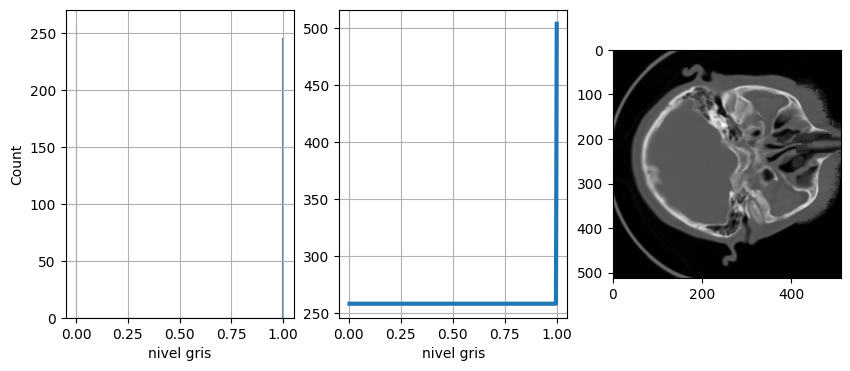

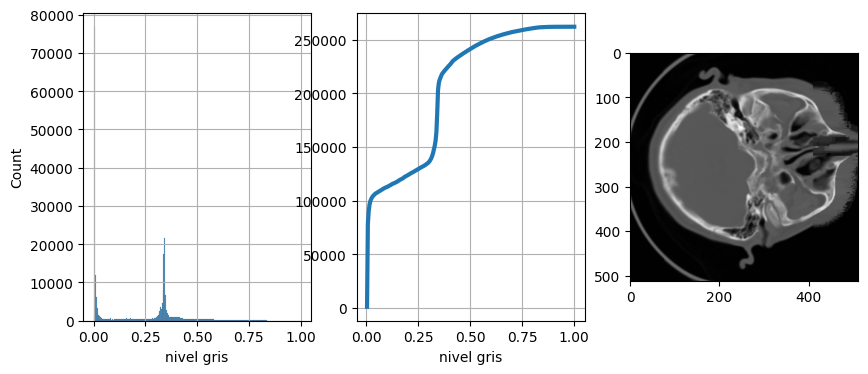

In [3]:
test = test_load[:,:,10]
img.explain_histogram(test, "gray")
norm = img.normalize_image(test)
img.explain_histogram(norm, "gray")

## Ecualizar

---

Ecualiza la imagen con los valores del umbral

img.equalize_image(imagen, valor minimo, valor máximo)


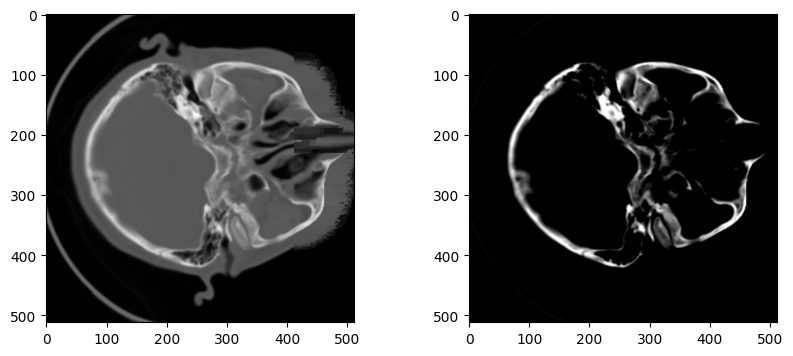

In [4]:
Image = img.equalize_image(norm, 0.4, 0.8)
img.show_two_normalized(norm, Image)

## Enmascaramiento (con umbral)

---


img.thresh_mask(imagen, valor minimo, valor máximo)

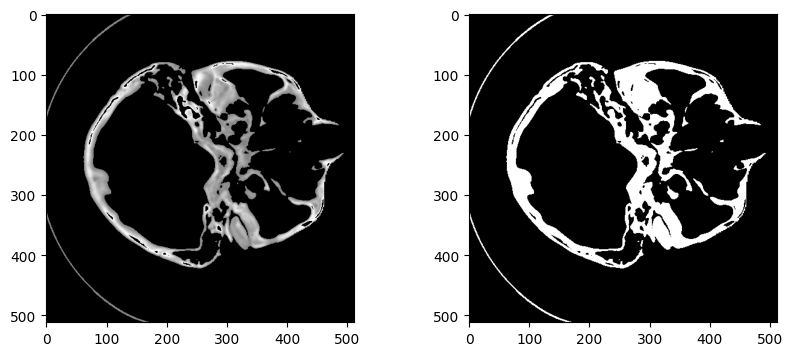

In [5]:
Image = img.thresh_mask(norm, 0.4, 0.8)
Image = img.normalize_image(Image)
img.show_two_normalized(norm * Image, Image)

## Kernel Gaussiano


---


img.Gauss(Tamaño del kernel, La desviación estandard de la gaussiana, La media de la gaussiana)

La desviación sirve para mover el foco de la imagen mientras que el media hace el efecto de un FILTRO pasabajas gaussiano


más ejemplos del código en: Kernel_Gauss_MexHat.ipynb


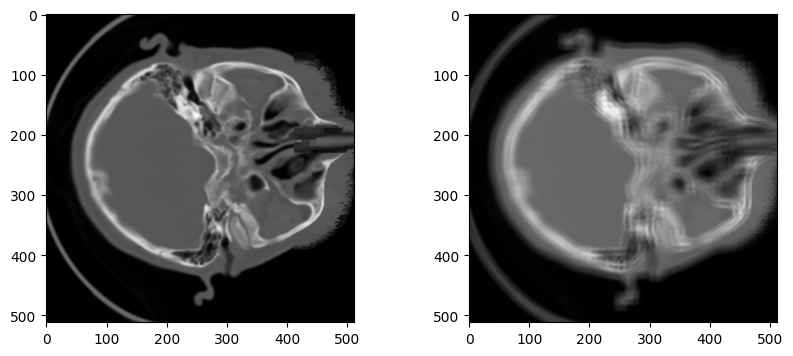

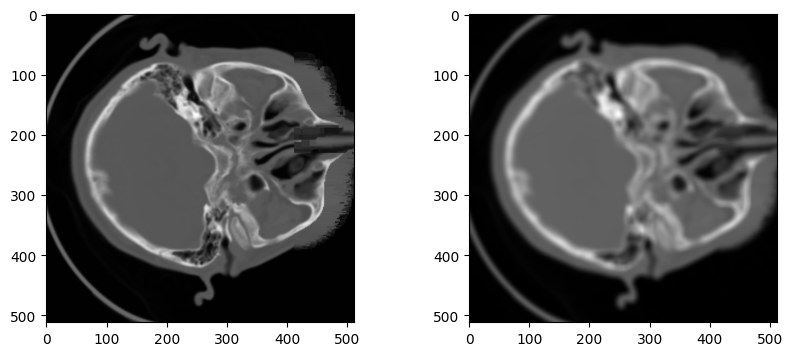

Esta functión ya ajusta el tamaño de las imágenes filtradas: (512, 512) (512, 512)


In [6]:
#             Tamaño std  media
#                 |   |  |
#                 v   v  v
Gauss = img.Gauss(5, 10, 1)

#                  Imagen  Kernel
#                   |       |
#                   v       v
Image = img.conv2d(norm, Gauss)
img.show_two_normalized(norm, Image) # Muestra dos imágenes en el mismo plot con un mapa de color el gris


Gauss = img.Gauss(5, 0, 10)
Image = img.conv2d(norm, Gauss)
img.show_two_normalized(norm, Image, "gray") # Muestra dos imágenes en el mismo plot con el mapa de color elegido


print("Esta functión ya ajusta el tamaño de las imágenes filtradas:", Image.shape, norm.shape)

## HighBoost

---


fimpy.highboost(Valor del centro, tipo)

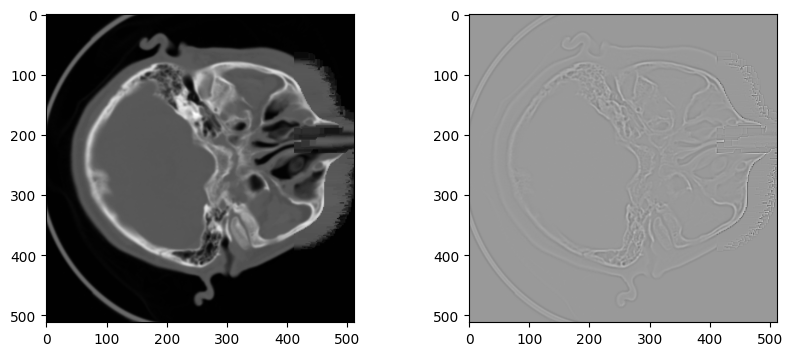

In [7]:
hb = img.highboost(8, 'dir')
Image = img.conv2d(norm, hb)
img.show_two_normalized(norm, np.abs(Image))

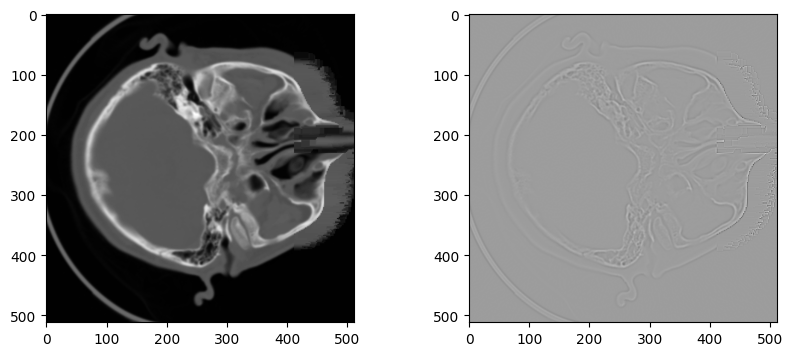

In [8]:
hb = img.highboost(4, 'lap')
Image = img.conv2d(norm, hb)
img.show_two_normalized(norm, np.abs(Image))

## Kernel Mexican Hat (wavlet)


---


img.mexhat(Tamaño del kernel, )

Esta funcion tiene una salida similar a la del filtro highboost, modulando el tamaño del pixel del centro con el segundo parámetro

https://colab.research.google.com/drive/1o1AMZTG9i2j-MJMzgH6oaiHXstQL7phz?usp=sharing

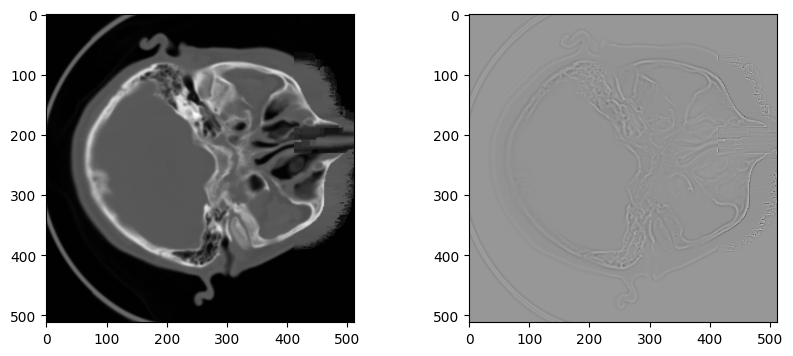

In [9]:
#                  Tamaño amplitud
#                   |      |
#                   v      v
MexHat = img.mexhat(5, 0.4)
Image = img.conv2d(norm, MexHat)
img.show_two_normalized(norm, np.abs(Image))

## Filtro Butterworth


---

Para usar este filtro se tiene que ingresar una imágen cuadrada. (mismo tamaño en 'x' y en 'y')

El tamaño del kernel debe de ser de (N (la longitud del arreglo en 'X' y 'Y') - 1) / 2
*   Kernel = fimpy.**Coords_Kernel**(Tamaño del kernel)
*   fimpy.**butter**(Kernel, frecuencia de corte, orden, tipo = (pasabajas o pasaltas)
*   fimpy.**imfiltfilt**(lena, filter); Aplica el filtro a la imagen.

más ejemplos del código en: https://colab.research.google.com/drive/18v4FZmVloMjMMtOBioiYoXKQRnt5kRTY?usp=sharing

512 512


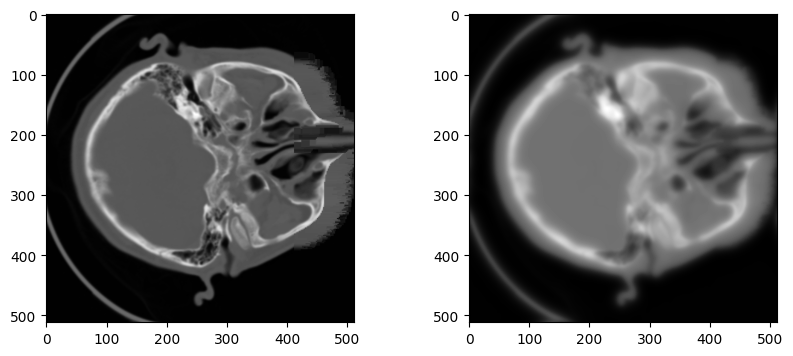

In [10]:
N, M =norm.shape
print(N, M)

# Se crean las coordenadas del kernel.
# Se debe de usar para esta aplicación la mitad de la longitud de la imágen
# La imágen debe de ser una imágen cuadrada 
Coord = img.Coords_Kernel((N-1)/2)

#                   Kernel  ws  N   tipo = ["lp", "hp"]   
#                      |     |  |     |
#                      v     v  v     v
filter = img.butter(Coord, 10, 3, 'lp')

# Se le aplica el filtro a la imagen
#                  Imagen Filtro
#                   |      |
#                   v      v
Image = img.imfilt(norm, filter)

img.show_two_normalized(norm, Image)

512 512


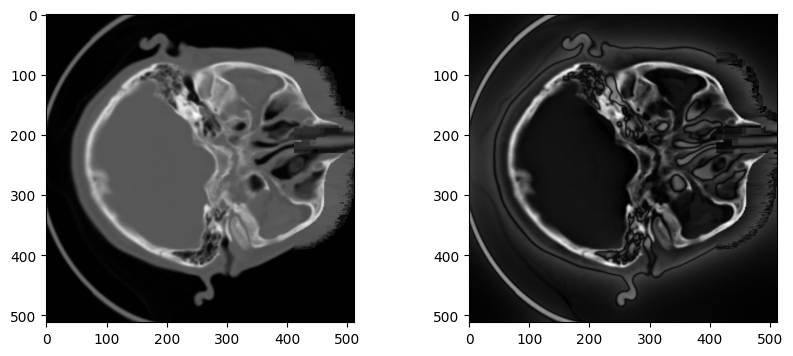

In [11]:
N, M =norm.shape
print(N, M)
Coord = img.Coords_Kernel((N-1)/2)
filter = img.butter(Coord, 5, 2, 'hp')
Image = img.imfilt(norm, filter)

img.show_two_normalized(norm, Image)

# Pipeline de filtrado usando la libreria

In [100]:
def filtra_scan(image):
    norm = img.normalize_image(test)
    equalizada = img.equalize_image(norm, 0.4, 1)

    N, M =equalizada.shape
    Coord = img.Coords_Kernel((N-1)/2)
    filter = img.butter(Coord, 5, 2, 'hp')
    pasa_altas = img.imfilt(equalizada, filter)
    pasa_altas = img.normalize_image(pasa_altas)

    Gauss = img.Gauss(5, 0, 15)
    Image = img.conv2d(pasa_altas, Gauss)

    Image = img.normalize_image(Image)
    mask = img.thresh_mask(Image, 0.25, 1)

    kernel = np.array(img.KernelCirc(3), dtype=np.float32)
    kernel = (kernel * 255).round().astype(np.uint8)

    iter = 3
    img_erosion = cv2.erode(mask, kernel, iterations=iter)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=iter)

    img_dilation = img.normalize_image(img_dilation)
    mascareada = img_dilation * norm

    mascareada = img.normalize_image(mascareada)
    return mascareada

In [103]:
test_load = nib.load('049.nii').get_fdata()
height, width, cut = test_load.shape
print(height, width, cut)
test = test_load[:, :, 10]

512 512 39


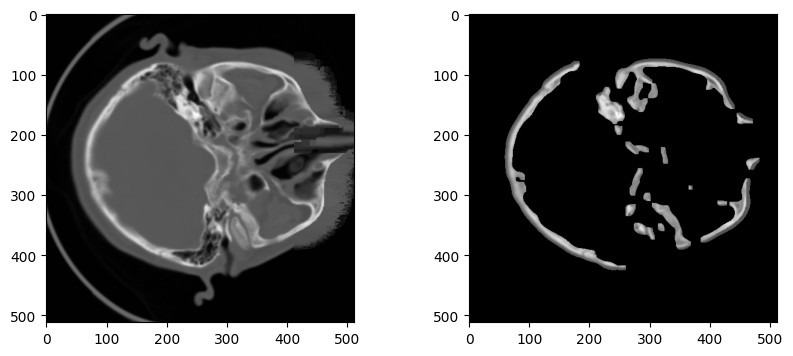

In [104]:
preprocesada = filtra_scan(test)
img.show_two_normalized(test, preprocesada)

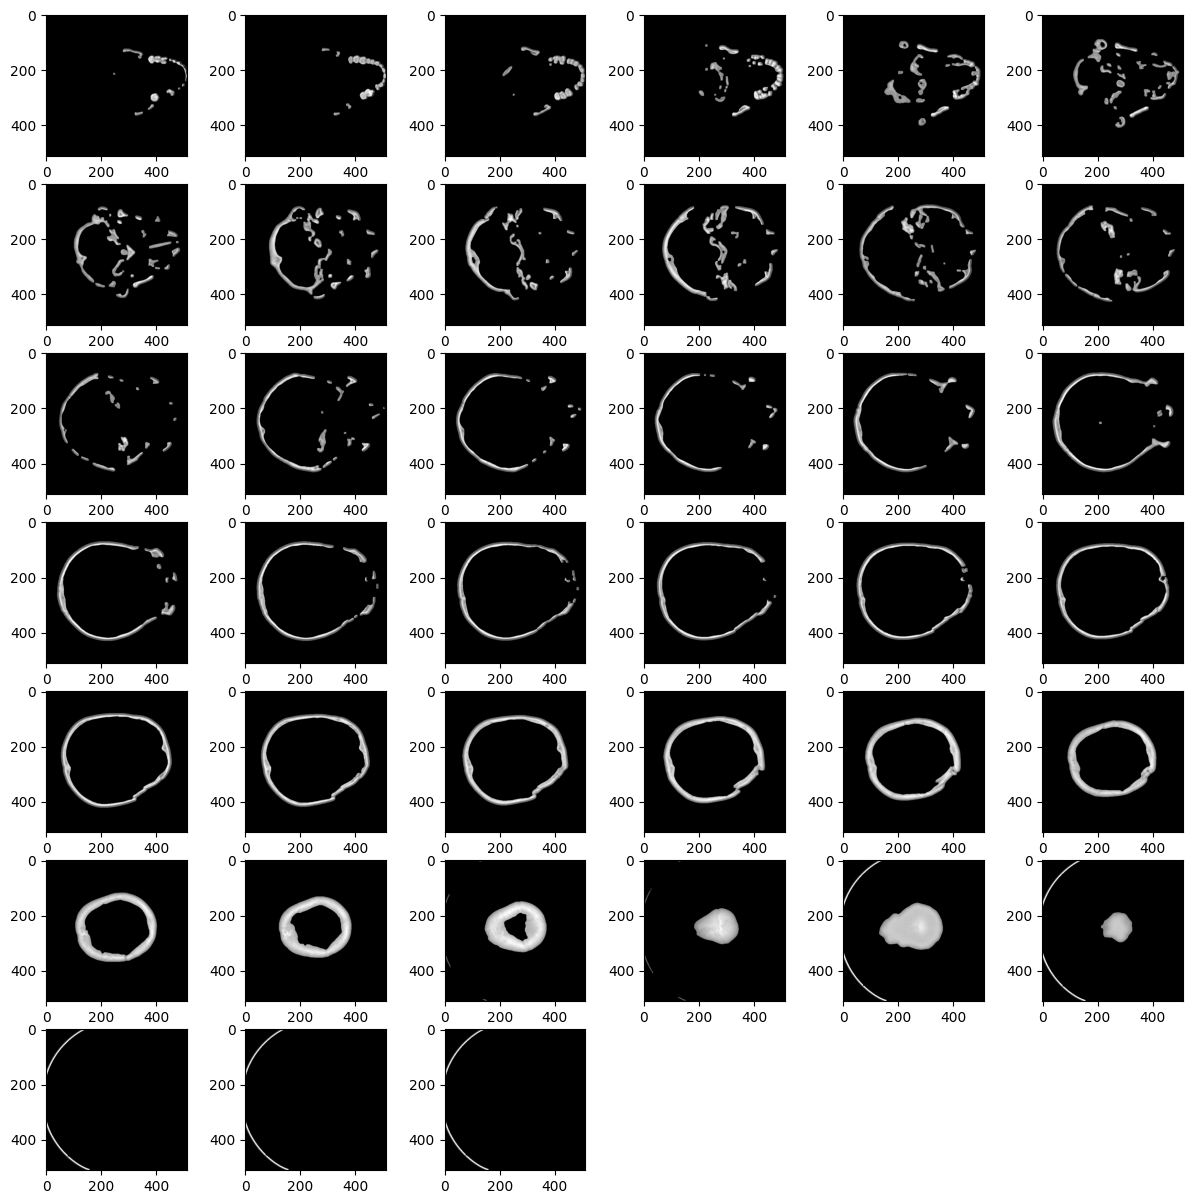

In [105]:
#plt.figure(figsize=(40, 40))
for i in range(0, cut):
    test = test_load[:, :, i]
    preprocesada = filtra_scan(test)
    plt.subplot(cut//5, 6,i + 1)
    plt.imshow(preprocesada, "gray")
    plt.gcf().set_size_inches(15, 15)
    #plt.axis("tight")
plt.show()

## Falta
---

* Filtro Cheby
* Cargar más funciones de wavlets
